# 1. Khai báo các thư viện cần sử dụng

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import matplotlib.pyplot as plt
import tensorflow as tf

from wordcloud import WordCloud
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 2. Thu thập dữ liệu

Tải tập dữ liệu ý kiến của người xem về phim trên IMDb

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 19s 0us/step


Xem các tệp và thư mục trong tập dữ liệu

# 3. Khám phá dữ liệu

In [ ]:
os.listdir(dataset_dir)

['README', 'train', 'test', 'imdbEr.txt', 'imdb.vocab']

Tạo thư mục chứa tập dùng để Huấn luyện và Thử nghiệm dữ liệu

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')

test_dir = os.path.join(dataset_dir, 'test')

Đọc 1 ý kiến tích cực

In [ ]:
sample_file = os.path.join(train_dir, 'pos/10000_8.txt')
with open(sample_file) as f:
  print(f.read())

Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days without th

# 4. Chuẩn bị dữ liệu

Xóa bỏ thư mục không cần thiết

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')

shutil.rmtree(remove_dir)

Tạo tập dữ liệu dùng để huấn luyện từ thư mục Train

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Khám phá dữ liệu ý kiến và kí hiệu nhãn dán

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Làm rõ tên nhãn dán

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Vẽ WordCloud tổng hợp từ vựng từ các ý kiến trong 2 thư mục Neg và Pos

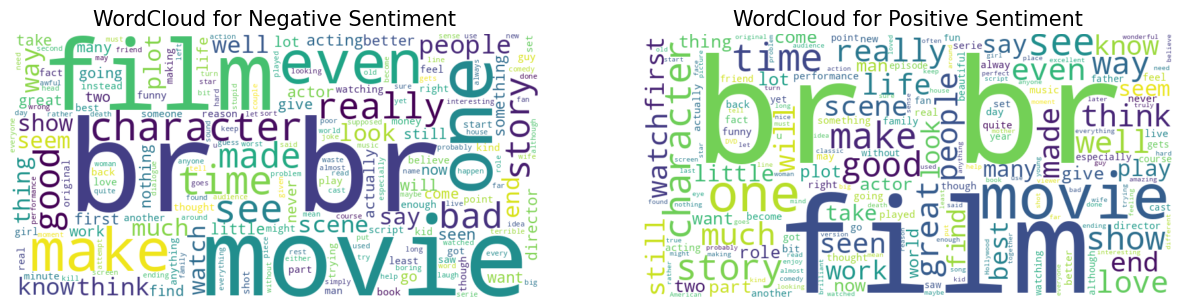

In [ ]:
def plot_word_cloud(texts, labels):
    # Tạo WordCloud cho văn bản có nhãn 0 (tích cực)
    combined_text = ' '.join([text.numpy().decode('utf-8') for text, label in zip(texts, labels) if label == 0])
    wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Tạo WordCloud cho văn bản có nhãn 1 (tiêu cực)
    combined_text = ' '.join([text.numpy().decode('utf-8') for text, label in zip(texts, labels) if label == 1])
    wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    # Vẽ hai WordClouds trên cùng một hình
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    # WordCloud cho nhãn 0
    axs[0].imshow(wordcloud_neg, interpolation='bilinear')
    axs[0].set_title('WordCloud for Negative Sentiment', fontsize=15)
    axs[0].axis('off')

    # WordCloud cho nhãn 1
    axs[1].imshow(wordcloud_pos, interpolation='bilinear')
    axs[1].set_title('WordCloud for Positive Sentiment', fontsize=15)
    axs[1].axis('off')

    # Hiển thị biểu đồ
    plt.show()

# Hàm này tạo WordCloud cho tất cả các văn bản trong tập huấn luyện và vẽ chúng
train_texts = []
train_labels = []
for text_batch, label_batch in raw_train_ds:
    train_texts.extend(text_batch)
    train_labels.extend(label_batch)

plot_word_cloud(train_texts, train_labels)


Tạo tập dữ liệu kiểm định từ thư mục Train

In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Tạo tập dữ liệu Kiểm thử từ thư mục Test

In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Tạo hàm chuẩn hóa dữ liệu văn bản, loại bỏ các kí tự, thẻ HTML, dấu câu

In [ ]:
def custom_standardization(input_data):
    # Chuyển đổi văn bản thành chữ thường
    lowercase = tf.strings.lower(input_data)
    # Loại bỏ các thẻ HTML
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    # Loại bỏ dấu câu
    return tf.strings.regex_replace(stripped_html,
                                     '[%s]' % re.escape(string.punctuation),
                                     '')

Tạo lớp chuyển đổi Văn bản thành Vector Embeddings.

In [ ]:
max_features = 10000
sequence_length = 269

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Ánh xạ chỉ lấy dữ liệu ý kiến để thực hiện chuyển thành Vector Embeddings

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Tạo hàm trả về bộ dữ liệu gồm Vector Embedding đại diện cho từ, và nhãn dán thể hiện ý kiến tích cực, tiêu cực tương ứng

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

Khám phá dữ liệu sau khi thực hiện nhúng

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[31], label_batch[31]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"This movie scared the crap out of me! I have to admit that I spent most of the film watching through my fingers but what I saw was really scary. I screamed out loud two or three times during the show.<br /><br />Film-making-wise my favorite aspects were the sound and photography. The sound was particularly great and the setting was really creepy beautiful. I read somewhere that it's some weird husband and wife team that made it. For some reason that makes this even stranger for me. <br /><br />If you enjoy the jumps and jitters of scary movies than this one is for you! Very suspenseful and a great movie to rent with a bunch of friends who love to watch movies curled up on a sofa screaming like little girls!", shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 269), dtype=int64, numpy=
array([[  11,   17, 1685,    2,  591,   44,    5,   69,   10,   25,    6,
         951,   12,   10, 1023,   88,    5,    2,   19,  146,  140,   54,
        5273,

Khám phá các từ ngữ mà Vector Embedding tương ứng đại diện

In [ ]:
print("591 ---> ",vectorize_layer.get_vocabulary()[591])
print(" 25 ---> ",vectorize_layer.get_vocabulary()[25])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

591 --->  crap
 25 --->  have
Vocabulary size: 10000


Thực hiện nhúng các bộ dữ liệu trong các tập dữ liệu

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Tối ưu quá trình tải dữ liệu bằng phương pháp tải dữ liệu song song, tối ưu hóa hiệu suất.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 5. Xây dựng, đào tạo và đánh giá mô hình

Xây dựng mô hình phân loại 2 lớp nhị phân

In [ ]:
embedding_dim = 32
dense_units = 64

model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.5),
    layers.Dense(dense_units, activation='relu'),  # Sử dụng hàm kích hoạt ReLU trong lớp Dense
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                        

Thiết lập quy trình huấn luyện cho mô hình

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])


Tối ưu quá trình huấn luyện

In [ ]:
# EarlyStopping callback
es = tf.keras.callbacks.EarlyStopping(
    patience=3,
    monitor='val_binary_accuracy',
    restore_best_weights=True
)

# ReduceLROnPlateau callback
lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=3,
    monitor='val_loss',
    factor=0.5,
    verbose=0
)

Tiến hành đào tạo mô hình

In [ ]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[lr, es]
)

Epoch 1/30
625/625 [==============================] - 36s 50ms/step - loss: 0.5877 - binary_accuracy: 0.6900 - val_loss: 0.3819 - val_binary_accuracy: 0.8468 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 3s 5ms/step - loss: 0.3369 - binary_accuracy: 0.8594 - val_loss: 0.3033 - val_binary_accuracy: 0.8738 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 3s 5ms/step - loss: 0.2705 - binary_accuracy: 0.8945 - val_loss: 0.2892 - val_binary_accuracy: 0.8802 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 3s 5ms/step - loss: 0.2365 - binary_accuracy: 0.9117 - val_loss: 0.2893 - val_binary_accuracy: 0.8806 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 3s 4ms/step - loss: 0.2123 - binary_accuracy: 0.9202 - val_loss: 0.2903 - val_binary_accuracy: 0.8838 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 3s 5ms/step - loss: 0.1932 - binary_accuracy: 0.9307 - val_loss: 0.3029 - val_binary_accuracy: 0.88

Đánh giá mô hình dựa trên tập Kiểm thử

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3315 - binary_accuracy: 0.8704
Loss:  0.3314829170703888
Accuracy:  0.8704000115394592


Lưu lại các chỉ số huấn luyện mô hình

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'lr'])

Trực quan hóa biểu đồ loss của quá trình huấn luyện và validation

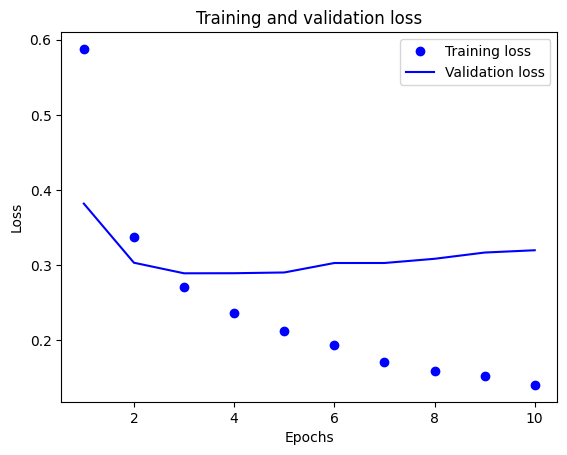

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Trực quan hóa biểu đồ độ chính xác của quá trình huấn luyện và validation

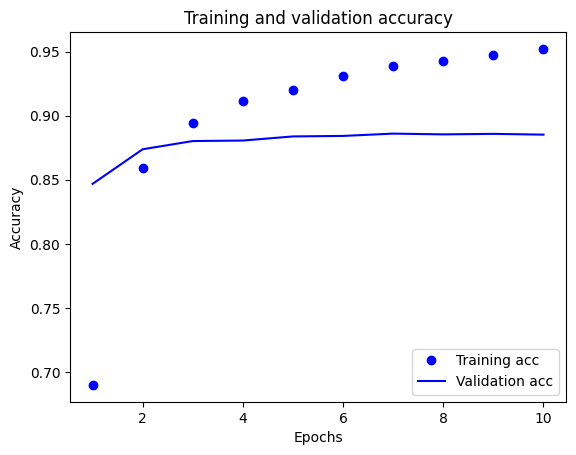

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Triển khai mô hình

Tạo một mô hình sử dụng lớp Vector hóa và mô hình phân loại nhị phân trước đó và lớp kích hoạt Sigmoid để đảm bảo đầu ra trong khoảng từ 0 đến 1

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Đánh giá mô hình trên dữ liệu thử nghiệm ban đầu chưa được xử lý và in ra độ chính xác

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 5ms/step - loss: 0.5767 - accuracy: 0.5001
0.5001199841499329


Thử nghiệm với những dữ liệu mới được truyền vào

In [ ]:
# Function to predict sentiment based on the trained model
def predict_sentiment_with_score(text, model):
    # Normalize the input text
    normalized_text = vectorize_layer([text])
    # Predict
    prediction = model.predict(normalized_text)[0][0]
    return prediction

# Examples to test the model
more_example_texts = [
    "The plot of the movie was intriguing and kept me engaged throughout.",
    "I was disappointed by the ending of the movie, it felt rushed and unsatisfying.",
    "The service at the hotel was terrible, the staff were rude and unhelpful.",
    "The soundtrack of the game was fantastic, it added so much to the overall experience.",
    "The user interface of the app was intuitive and easy to navigate.",
    "The quality of the product was very poor, it broke after just a few uses.",
    "The atmosphere in the restaurant was cozy and welcoming, I enjoyed my dining experience.",
]

# Testing the model with more examples
for text in more_example_texts:
    prediction_score = predict_sentiment_with_score(text, model)
    sentiment = "Positive" if prediction_score > 0.5 else "Negative"
    print(f"Text: '{text}'")
    print(f"Predicted sentiment: {sentiment}")
    print(f"Prediction score: {prediction_score}")
    print()


1/1 [==============================] - 0s 91ms/step
Text: 'The plot of the movie was intriguing and kept me engaged throughout.'
Predicted sentiment: Positive
Prediction score: 0.7270663976669312

1/1 [==============================] - 0s 26ms/step
Text: 'I was disappointed by the ending of the movie, it felt rushed and unsatisfying.'
Predicted sentiment: Negative
Prediction score: 0.3358563780784607

1/1 [==============================] - 0s 28ms/step
Text: 'The service at the hotel was terrible, the staff were rude and unhelpful.'
Predicted sentiment: Negative
Prediction score: 0.16792970895767212

1/1 [==============================] - 0s 29ms/step
Text: 'The soundtrack of the game was fantastic, it added so much to the overall experience.'
Predicted sentiment: Positive
Prediction score: 0.891494631767273

1/1 [==============================] - 0s 32ms/step
Text: 'The user interface of the app was intuitive and easy to navigate.'
Predicted sentiment: Positive
Prediction score: 0.745